In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Notebook Agenda**

---

## **1. Introduction**
- **Overview of the Assignment:** A brief explanation of the purpose and tasks.
- **Objectives and Goals:** Expected outcomes from this notebook.

---

## **2. Data Description**
- **Sample Texts:**
  - Arabic sample text with issues.
  - English sample text with issues.
- **Key Observations:**
  - Common text issues (misspellings, mixed languages, punctuation).

---

## **3. Preprocessing Pipeline**

### **3.1 Normalization**
- **Arabic Text:**
  - Remove diacritics.
  - Normalize letter variations (e.g., `أ`, `إ` → `ا`).
- **English Text:**
  - Convert to lowercase.
  - Remove unnecessary punctuation.

### **3.2 Tokenization**
- **Definition and Purpose:** Breaking text into words.
- **Tools Used:**
  - For Arabic: `Farasa`, `PyArabic`.
  - For English: `NLTK`, `spaCy`.

### **3.3 Stopword Removal**
- **Arabic Stopwords:** Use predefined lists for Arabic.
- **English Stopwords:** Use tools like `nltk.corpus`.

### **3.4 Spelling Correction**
- **Arabic Text:** Handle common typos using specific libraries.
- **English Text:** Fix misspellings using tools like `pyspellchecker`.

### **3.5 Handling Mixed Languages**
- **Detect Mixed Tokens:** Identify Arabic and English tokens in the same text.
- **Clean Mixed Tokens:** Process each token based on its language.

---

## **4. Word2Vec Representation**

### **4.1 Training Word2Vec Models**
- **English Text:**
  - Train a Word2Vec model using the preprocessed English data.
- **Arabic Text:**
  - Train a Word2Vec model using the preprocessed Arabic data.

### **4.2 Extracting Embeddings**
- Display word embeddings for **five words** from:
  - English text.
  - Arabic text.

---

## **5. Results and Discussion**
- **Cleaned Texts:**
  - Preprocessed Arabic text.
  - Preprocessed English text.
- **Word Embeddings:**
  - Visualization or analysis of word vectors.
- **Insights:**
  - Observations on embeddings and challenges faced during preprocessing.

---

In [2]:
pip install pyspellchecker

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install googletrans==4.0.0-rc1

Note: you may need to restart the kernel to use updated packages.


In [21]:
import re
import pyarabic.araby as araby
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from spellchecker import SpellChecker
import requests
import json
from googletrans import Translator
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np

## Text Normalization

Text normalization is the process of transforming text into a standard, consistent format. This is an essential step in text preprocessing, especially when working with natural language processing (NLP) tasks. The goal of normalization is to reduce variations in the text to make it easier to process and analyze. Below are the common techniques used in text normalization:

### 1. **Lowercasing**
   - **Purpose**: Converts all characters to lowercase.
   - **Why**: This ensures that words like "Apple" and "apple" are treated as the same word. It helps in case-insensitive analysis.

### 2. **Removing Punctuation**
   - **Purpose**: Strips all punctuation marks (e.g., commas, periods, exclamation marks).
   - **Why**: Punctuation is often not relevant in text analysis tasks such as sentiment analysis or topic modeling, and removing it helps reduce noise.

### 3. **Removing Numbers**
   - **Purpose**: Deletes any numbers from the text.
   - **Why**: Unless the numbers are important (such as for tasks involving numerical data), removing them simplifies the text for other tasks.

### 4. **Removing Extra Spaces**
   - **Purpose**: Replaces multiple spaces with a single space and removes leading/trailing spaces.
   - **Why**: Extra spaces can create inconsistencies in the data, and removing them ensures uniform spacing for easier tokenization and analysis.

### 5. **Handling Special Characters and Variations**
   - **Purpose**: Normalizes variations of special characters or letters. For example, in Arabic, characters like `أ`, `إ`, `آ` are converted to a single `ا`, or in English, characters like `co-operation` can be simplified to `cooperation`.
   - **Why**: Reducing character variations ensures consistency across the text and prevents the model from treating them as different entities.

### Why Normalization Is Important:
Normalization reduces unnecessary complexity in the text, enabling models to focus on the core content. It simplifies the data, removes inconsistencies, and ensures that the model can generalize better. Without normalization, the model may struggle with variations in spelling, punctuation, or other factors that don’t affect the meaning of the text.

In [5]:
def normalize_arabic_text(text):
    # 1. Convert all forms of 'Alef' (أ, إ, آ) to 'ا'
    text = re.sub(r'[أإآ]', 'ا', text)
    
    # 2. Convert 'Yaa' (ى) to 'Ya' (ي)
    text = re.sub(r'ى', 'ي', text)
    
    # 3. Convert 'Taa Marbuta' (ة) to 'Haa' (ه)
    text = re.sub(r'ة', 'ه', text)
    
    # 4. Remove all diacritics (harakat)
    text = re.sub(r'[ًٌٍَُِّْ]', '', text)
    
    # 5. Remove duplicate characters (if any letter repeats, keep only one)
    text = re.sub(r'(.)\1+', r'\1', text)
    
    # 6. Remove punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
    
    # 7. Remove numbers
    text = re.sub(r'[0-9]', '', text)
    
    # 8. Remove extra spaces and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


In [32]:
def normalize_english_text(text):
    # 1. Convert all text to lowercase
    text = text.lower()
    
    # 2. Remove punctuation marks (commas, periods, exclamation marks, etc.)
    text = re.sub(r'[^\w\s]', '', text)
    
    # 3. Remove numbers
    text = re.sub(r'[0-9]', '', text)

    # 4.Handle words with hyphens like "co-operation" and convert them to "cooperation"
    text = re.sub(r'\b([a-zA-Z]+)[-]([a-zA-Z]+)\b', r'\1\2', text)  
    
    # 5. Remove extra spaces and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Tokenization in Natural Language Processing (NLP)

## What is Tokenization?
Tokenization is the process of breaking down text into smaller units, called tokens. These tokens can be words, characters, or subwords. Tokenization is one of the first steps in many Natural Language Processing (NLP) tasks as it transforms unstructured text into a more manageable format for analysis.

## Types of Tokenization
1. **Word Tokenization**: In this type, the text is split into individual words. This is the most common approach, especially when working with tasks like text classification, named entity recognition, or sentiment analysis.

    Example:
    - Input: "I love programming."
    - Output: `["I", "love", "programming"]`

2. **Sentence Tokenization**: In this type, the text is split into individual sentences. Sentence tokenization is useful for tasks that require understanding sentence boundaries, such as machine translation or summarization.

    Example:
    - Input: "I love programming. It's amazing."
    - Output: `["I love programming.", "It's amazing."]`

3. **Subword Tokenization**: This technique breaks words into smaller meaningful units, such as prefixes, suffixes, or even characters. This is useful when dealing with out-of-vocabulary words in languages with rich morphology, like Arabic or German.

    Example:
    - Input: "unhappiness"
    - Output: `["un", "happiness"]`

4. **Character Tokenization**: In this type, the text is split into individual characters. This is typically used in character-level language models or for languages that don't use spaces between words (e.g., Chinese, Japanese).

    Example:
    - Input: "hello"
    - Output: `["h", "e", "l", "l", "o"]`

## Why Tokenization is Important?

Tokenization is a key step in NLP that:

1. **Prepares text for further processing**: It helps with tasks like part-of-speech tagging, named entity recognition (NER), and machine translation by breaking text into manageable units (tokens).

2. **Converts unstructured text into structured data**: Tokenization makes raw text suitable for analysis and machine learning models by transforming it into individual tokens, which can then be numerically represented.

3. **Facilitates text analysis**: By splitting text into tokens, it becomes easier to analyze word frequency, detect patterns, and extract features for tasks like sentiment analysis or topic modeling.

4. **Improves model efficiency**: Tokenization reduces the complexity of processing long texts, making models faster and more efficient by focusing on smaller chunks of data.

In essence, tokenization is crucial for preparing text data, enabling effective model training, and simplifying text analysis.


In [7]:
def tokenize_arabic_text(text):
    # Tokenize Arabic text into words using pyarabic
    tokens = araby.tokenize(text)
    return tokens

In [33]:
# Download necessary NLTK resources
nltk.download('punkt')

def tokenize_english_text(text):
    # Tokenize the text into words using NLTK's word_tokenize function
    tokens = word_tokenize(text)
    return tokens

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Stopword Removal in Text Processing

**Stopword removal** is an essential preprocessing step in Natural Language Processing (NLP) where common words that do not contribute much meaning are removed from the text. These words, known as **stopwords**, include conjunctions, prepositions, articles, and other function words such as *"is," "the," "in,"* and *"and."*

## Why is Stopword Removal Important?

1. **Reducing Noise**: Stopwords can clutter the text and interfere with more important words, making it harder for models to identify key patterns.
   
2. **Improving Efficiency**: Removing stopwords reduces the size of the text, which helps speed up the processing and improves the model's performance.

3. **Enhancing Model Accuracy**: By removing these unimportant words, the model can focus on content-heavy words that carry more information, improving tasks like sentiment analysis, topic modeling, and text classification.

## How to Remove Stopwords

Stopword removal can be done using libraries like NLTK in Python, which provide predefined lists of stopwords for various languages. The process involves filtering out these words from the text, leaving only the significant ones.

## Challenges in Stopword Removal

- **Context-Specific**: Sometimes, words that are typically stopwords may have significant meaning depending on the context. This is especially true for specialized domains, where some words might not be considered stopwords.
  
- **Custom Stopword Lists**: Predefined stopword lists may not always be sufficient for specific tasks. In such cases, you may need to create custom stopword lists tailored to your specific dataset or application.

## Conclusion

Stopword removal is a crucial step to streamline text data and ensure that models can focus on the key information, making the analysis more effective and efficient.


In [9]:
# Load Arabic stopwords list
stop_words = stopwords.words("arabic")

def remove_stopwords_arabic(text):

    words = tokenize_arabic_text(text)

    # Filter out the stopwords
    filtered_words = [word for word in words if word not in stop_words]
    
    # Join the words back into a single string
    return " ".join(filtered_words)

In [34]:
# Load the English stopwords list from NLTK
stop_words = stopwords.words("english")

def remove_stopwords_english(text):

    words = tokenize_english_text(text)

    # Filter out the stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Join the words back into a single string
    return " ".join(filtered_words)

# Spelling Correction in Natural Language Processing (NLP)

Spelling correction refers to the process of identifying and fixing misspelled words in a given text. It is an important task in Natural Language Processing (NLP) that aims to enhance the quality of text by correcting spelling mistakes. This process helps in improving text understanding and can be used in applications like text processing, search engines, and chatbot interactions.

## Steps Involved in Spelling Correction

1. **Text Preprocessing:**
   - Before performing spelling correction, the text may be preprocessed to remove any unnecessary elements like punctuation, numbers, or special characters.
   - Tokenization may also be applied to break the text into words.

2. **Error Detection:**
   - The first step in spelling correction is identifying words that may be misspelled.
   - This can be done using a dictionary or a predefined list of correct words. Words not found in the dictionary are flagged as potential errors.

3. **Error Suggestion:**
   - Once a misspelled word is detected, a list of possible correct words (suggestions) is generated.
   - Algorithms like **Edit Distance** (Levenshtein distance) or **Soundex** can be used to find the closest possible matches to the misspelled word.

4. **Error Correction:**
   - The system selects the most likely correct word from the suggestions list based on context, frequency, and probability.
   - Some spelling correction models also use **contextual information** (e.g., grammar rules or machine learning models) to choose the most appropriate correction.

5. **Post-Processing:**
   - After correcting spelling errors, the final text may undergo additional checks for formatting, punctuation, or grammar.
   - The corrected text is then returned as output.

## Common Techniques for Spelling Correction

1. **Dictionary-based Correction:**
   - A dictionary of valid words is used to compare the input word with known correct words. If a word is not found in the dictionary, it is considered incorrect.
   - Suggestions are based on words that are close to the misspelled word.

2. **Edit Distance Algorithm (Levenshtein Distance):**
   - Levenshtein distance calculates the number of single-character edits (insertions, deletions, or substitutions) required to transform one word into another.
   - The word with the smallest edit distance is considered the most likely correction.

3. **Context-based Correction:**
   - This method uses the context of the word in a sentence to suggest corrections. For example, a misspelling might be corrected differently depending on the surrounding words.

4. **Statistical and Machine Learning Models:**
   - Advanced models, like those using **n-grams** or **deep learning**, can predict the most likely correction based on large corpora of text.
   - These models learn from data to understand common spelling errors and context.


In [11]:
def correct_arabic_text(text, api_key):
    # API URL
    url = 'https://farasa.qcri.org/webapi/spellcheck/'

    # Data to be sent with the request
    payload = {'text': text, 'api_key': api_key}

    # Sending the request
    data = requests.post(url, data=payload)

    # Checking the response status
    if data.status_code == 200:
        # Trying to parse the response as JSON
        try:
            result = data.json()  # Using .json() instead of json.loads
            corrections = result.get('text', '')
            
            # Removing text after "/" using regular expressions
            corrected_text = re.sub(r'/[^ ]+', '', corrections)  # Removing text after "/"
            
            return corrected_text
        
        except json.JSONDecodeError:
            return "Invalid response from the API: " + data.text
    else:
        return f"Error in request: {data.status_code} - {data.text}"

# Using the function
api_key = "JLmgCKcjFkXZrBjNEx"

In [35]:
from spellchecker import SpellChecker

# Initialize the spell checker
spell = SpellChecker()

# Dictionary containing common abbreviations and their full forms
abbreviations = {
    # Titles
    "Dr.": "Doctor",
    "Mr.": "Mister",
    "Mrs.": "Misses",
    "Ms.": "Miss",
    "St.": "Saint",

    # Common Chat Abbreviations
    "gr8": "great",
    "b4": "before",
    "u": "you",
    "r": "are",
    "ur": "your",
    "pls": "please",
    "thx": "thanks",
    "np": "no problem",
    "idk": "I don't know",
    "imo": "in my opinion",
    "btw": "by the way",
    "afaik": "as far as I know",
    "brb": "be right back",
    "gtg": "got to go",
    "ttyl": "talk to you later",
    "omg": "oh my god",
    "lol": "laugh out loud",
    "rofl": "rolling on the floor laughing",
    "lmao": "laughing my ass off",
    "smh": "shaking my head",
    "fyi": "for your information",
    "yolo": "you only live once",
    "tmi": "too much information",
    "ikr": "I know, right?",
    "idc": "I don't care",
    "jk": "just kidding",
    "nvm": "never mind",
    "wbu": "what about you?",
    "wyd": "what are you doing?",
    "lmk": "let me know",
    "rn": "right now",
    "tho": "though",
    "ty": "thank you",
    "yw": "you're welcome",

    # Business/Professional
    "CEO": "Chief Executive Officer",
    "CFO": "Chief Financial Officer",
    "CTO": "Chief Technology Officer",
    "B2B": "Business to Business",
    "B2C": "Business to Consumer",
    "ASAP": "as soon as possible",
    "FYI": "for your information",
    "ETA": "estimated time of arrival",
    "TBD": "to be determined",
    "TBA": "to be announced",
    "FAQ": "frequently asked questions",
    "RSVP": "Répondez s'il vous plaît",
    "POV": "point of view",

    # Technology/Internet
    "WiFi": "wireless fidelity",
    "NFT": "non-fungible token",
    "IP": "internet protocol",
    "HTTP": "hypertext transfer protocol",
    "HTTPS": "secure hypertext transfer protocol",
    "DNS": "domain name system",
    "URL": "uniform resource locator",
    "SEO": "search engine optimization",
    "UI": "user interface",
    "UX": "user experience",
    "AI": "artificial intelligence",
    "ML": "machine learning",
    "VR": "virtual reality",
    "AR": "augmented reality",
    "IoT": "internet of things",
    "QR": "quick response",

    # Social Media
    "DM": "direct message",
    "PM": "private message",
    "TBT": "throwback Thursday",
    "OOTD": "outfit of the day",
    "FOMO": "fear of missing out",
    "IMO": "in my opinion",
    "TBH": "to be honest",
    "IRL": "in real life",
    "AMA": "ask me anything",
    "ICYMI": "in case you missed it",
    "NSFW": "not safe for work",
    "BFF": "best friends forever",
    "OTP": "one true pairing",

    # Others
    "DOB": "date of birth",
    "ETA": "estimated time of arrival",
    "DIY": "do it yourself",
    "TGIF": "thank god it's Friday",
    "MIA": "missing in action",
    "AFK": "away from keyboard",
    "GG": "good game",
    "GLHF": "good luck have fun",
    "YOLO": "you only live once",
    "TTYL": "talk to you later",
    "TYT": "take your time",
}


# Function to correct spelling in a given text
def correct_english_text(text):
    # Replace abbreviations with full forms
    for abbrev, full_form in abbreviations.items():
        text = text.replace(abbrev, full_form)
    
    # Tokenize the text into words
    words = tokenize_english_text(text)

    # Find and correct the misspelled words
    corrected_text = []
    for word in words:
        if spell.unknown([word]):  # Check if the word is misspelled
            corrected_word = spell.correction(word)
            corrected_text.append(corrected_word if corrected_word else word)  # Ensure valid string
        else:
            corrected_text.append(word)

    # Join the corrected words into a single string
    return ' '.join(corrected_text)


# Handling Mixed Languages in NLP

Handling mixed-language text refers to processing text that includes words or phrases from more than one language. This is common in informal communications like social media, casual conversations, or multilingual documents, where a person might switch between languages, often within the same sentence or phrase. Handling this type of text efficiently requires special techniques and tools.

---

## Challenges of Mixed-Language Text

1. **Language Identification:**
   - Identifying which parts of the text belong to which language can be tricky, especially when certain words may appear in more than one language with different meanings.
  
2. **Tokenization:**
   - Tokenizing mixed-language text can be challenging because different languages have different grammatical rules and writing systems. Properly identifying words is harder when multiple languages coexist.

3. **Translation:**
   - Translating words or sentences from one language to another while ensuring that the original meaning is preserved requires special handling when the text includes multiple languages.

4. **Contextual Understanding:**
   - Mixed-language text may contain cultural nuances, idioms, and expressions that vary between languages. Understanding the context is essential to properly process and translate mixed-language text.

5. **Code-Switching:**
   - This refers to the practice of switching between languages within a sentence or conversation. Handling such switches requires algorithms capable of distinguishing and processing the different languages.

---

## Techniques for Handling Mixed-Language Text

1. **Language Detection:**
   - Use language detection libraries like `langdetect` or `langid` to identify the language of individual words or sentences in a mixed-language text.
   
2. **Script Identification:**
   - Use Unicode properties to identify different scripts (e.g., Arabic, Latin, Cyrillic), which helps in differentiating languages based on the script used.

3. **Machine Translation:**
   - Employ machine translation systems like Google Translate, Hugging Face Transformers, or OpenNMT to translate individual words or phrases from one language to another.
   
4. **Named Entity Recognition (NER):**
   - Use NER to identify and extract proper nouns, which are often language-agnostic (e.g., names of people, locations, organizations). This can help with language-specific processing tasks.

5. **Tokenization and Word Segmentation:**
   - Special tokenizers that support multiple languages can help in breaking down mixed-language text into meaningful tokens. Some tokenization tools are built to work with code-switching scenarios, handling multilingual text more effectively.

---

## Example Process for Handling Mixed-Language Text

Here's a simplified process for handling mixed-language text:

1. **Extract English Words from Arabic/English Text:**
   - First, use regular expressions to identify and extract words that are in English from a text that contains both Arabic and English.

2. **Translate English Words:**
   - Use a translation API (e.g., Google Translate) to translate the English words into Arabic or vice versa.

3. **Replace Translated Words Back into Text:**
   - Once the words are translated, replace the original English words in the text with their Arabic translations.

---

In [13]:
def translate_text_to_arabic(text):
    """
    Translates mixed-language text to Arabic. Detects and translates only non-Arabic words or sentences.
    """
    translator = Translator()
    translated_text = []
    pattern = re.compile(r'[a-zA-Z]')
    
    # Split the text into sentences
    sentences = re.split(r'([.!؟])', text)
    sentences = [s.strip() for s in sentences if s.strip()]  # Remove empty parts
    
    for sentence in sentences:
        if pattern.search(sentence):  # If the sentence contains English letters
            try:
                translated_sentence = translator.translate(sentence, src='en', dest='ar').text
                translated_text.append(translated_sentence)
            except Exception as e:
                print(f"Error translating sentence '{sentence}': {e}")
                translated_text.append(sentence)  # Keep the original if translation fails
        else:
            translated_text.append(sentence)  # Keep Arabic sentences as they are
    
    return ''.join(translated_text)


In [36]:
def translate_text_to_english(text):
    """
    Translates mixed-language text to English. Detects and translates only non-English words or sentences.
    """
    translator = Translator()
    translated_text = []
    pattern = re.compile(r'[ء-ي]')  # نمط للكشف عن الحروف العربية
    
    # Split the text into sentences
    sentences = re.split(r'([.!؟])', text)
    sentences = [s.strip() for s in sentences if s.strip()]  # Remove empty parts
    
    for sentence in sentences:
        if pattern.search(sentence):  # If the sentence contains Arabic letters
            try:
                translated_sentence = translator.translate(sentence, src='ar', dest='en').text
                translated_text.append(translated_sentence)
            except Exception as e:
                print(f"Error translating sentence '{sentence}': {e}")
                translated_text.append(sentence)  # Keep the original if translation fails
        else:
            translated_text.append(sentence)  # Keep English sentences as they are
    
    return ' '.join(translated_text)


# example

In [16]:
text = """الثورة الصناعية الثانية المعروفة أيضًا باسم الثورة التكنولوجية، هي مرحلة من التوحيد المعياري والتصنيع السريع التي بدأت بشكل عام في سنة 1870 واستمرت إلى بداية الحرب العالمية الأولى سنة 1914. وكانت الثورة الصناعية الأولى قد تباطئت في الاختراعات المهمة حتى انتهت قبيل اندلاع الثورة الصناعية الثانية في 1870، التي يمكن إرجاع بعض أحداثها إلى الابتكارات السابقة في التصنيع، مثل إنشاء صناعة عدة الصيانة، وتطوير طرق تصنيع الأجزاء القابلة للتبديل، واختراع عملية بسمر لتصنيع الصلب وكهربة المصانع وإنشاء خطوط الإنتاج.

مكنت التطورات في التصنيع والإنتاج من تبني قوي للأنظمة التكنولوجية مثل شبكات التلغراف والسكك الحديدية وإمدادات المياه والغاز وأنظمة الصرف الصحي، وقد كانت مركزة في وقت سابق في عدد قليل من المدن المختارة. سمح التوسع الهائل لخطوط السكك الحديدية والتلغراف بعد 1870 بانتقال غير مسبوق للأشخاص والأفكار، وبلغت ذروتها بموجة جديدة من العولمة. بالإضافة فقد أُدخلت أنظمة تكنولوجية جديدة، وأهمها الطاقة الكهربائية والهواتف.
te
شهدت الثورة الصناعية الثانية طفرة من التطور الصناعي السريع في أوروبا الغربية (بريطانيا وألمانيا وفرنسا والبلدان المنخفضة) وكذلك الولايات المتحدة الأمريكية واليابان. وقد جاءت هذه الثورة بعد الثورة الصناعية الأولى التي بدأت في بريطانيا أواخر القرن الثامن عشر ثم انتشرت في جميع أنحاء أوروبا الغربية."""

text = translate_text_to_arabic(text)
text = normalize_arabic_text(text)
arabic_text = remove_stopwords_arabic(text)
#text = correct_arabic_text(text, api_key)
print(arabic_text)

الثوره الصناعيه الثانيه المعروفه ايضا باسم الثوره التكنولوجيه هي مرحله من التوحيد المعياري والتصنيع السريع التي بدات بشكل عام في سنه واستمرت الي بدايه الحرب العالميه الاولي سنه وكانت الثوره الصناعيه الاولي قد تباطئت في الاختراعات المهمه حتي انتهت قبيل اندلاع الثوره الصناعيه الثانيه في التي يمكن ارجاع بعض احداثها الي الابتكارات السابقه في التصنيع مثل انشاء صناعه عده الصيانه وتطوير طرق تصنيع الاجزاء القابله لتبديل واختراع عمليه بسمر لتصنيع الصلب وكهربه المصانع وانشاء خطوط الانتاجمكنت التطورات في التصنيع والانتاج من تبني قوي لانظمه التكنولوجيه مثل شبكات التلغراف والسك الحديديه وامدادات المياه والغاز وانظمه الصرف الصحي وقد كانت مركزه في وقت سابق في عد قليل من المدن المختارهسمح التوسع الهائل لخطوط السك الحديديه والتلغراف بعد بانتقال غير مسبوق لاشخاص والافكار وبلغت ذروتها بموجه جديده من العولمهبالاضافه فقد ادخلت انظمه تكنولوجيه جديده واهمها الطاقه الكهربائيه والهواتفتي شhadt alثorه alصnauiه chloyath chlmtحdه chalاmeryكiه و alyaibanوقد جاءت هذه الثوره بعد الثوره الصناعيه الاولي التي بدات في ب

In [37]:
text = """England in the Middle Ages concerns the history of England during the medieval period, from the end of the 5th century through to the start of the early modern period in 1485. When England emerged from the collapse of the Roman Empire, the economy was in tatters and many of the towns abandoned.
After several centuries of Germanic immigration, new identities and cultures began to emerge, developing into kingdoms that competed for power. A rich artistic culture flourished under the Anglo-Saxons, producing epic poems such as Beowulf and sophisticated metalwork.
The Anglo-Saxons converted to Christianity in the 7th century, and a network of monasteries and convents were built across England. In the 8th and 9th centuries, England faced fierce Viking attacks, and the fighting lasted for many decades.
Eventually, Wessex was established as the most powerful kingdom and promoted the growth of an English identity. Despite repeated crises of succession and a Danish seizure of power at the start of the 11th century,
it can also be argued that by the 1060s England was a powerful, centralised state with a strong military and successful economy."""

text = translate_text_to_english(text)
text = normalize_english_text(text)
text = remove_stopwords_english(text)
english_text = correct_english_text(text)
print(text)

england middle ages concerns history england medieval period end th century start early modern period england emerged collapse roman empire economy tatters many towns abandoned several centuries germanic immigration new identities cultures began emerge developing kingdoms competed power rich artistic culture flourished anglosaxons producing epic poems beowulf sophisticated metalwork anglosaxons converted christianity th century network monasteries convents built across england th th centuries england faced fierce viking attacks fighting lasted many decades eventually wessex established powerful kingdom promoted growth english identity despite repeated crises succession danish seizure power start th century also argued england powerful centralised state strong military successful economy


# **Word2Vec**

## **What is Word2Vec?**
Word2Vec is a powerful algorithm for learning vector representations of words in a continuous vector space. It helps represent words as dense numerical vectors, capturing their semantic meanings based on context. It was developed by a team at Google in 2013 and is widely used in NLP tasks.

---

## **Key Concepts**

### **Word Embedding**
- A word embedding is a dense, fixed-size vector representation of a word.
- Words with similar meanings or usage tend to have embeddings closer together in vector space.
- Example: The embeddings for "king" and "queen" are semantically close.

### **Contextual Learning**
- Word2Vec learns word meanings by analyzing the context in which words appear in a corpus.
- For instance, in a sentence like _"The cat sat on the mat"_, the word "cat" will learn an embedding influenced by "sat," "mat," and "on."

---

## **Architectures in Word2Vec**

### **1. Skip-Gram**
- **Goal**: Predict surrounding context words given a target word.
- **Example**: In the sentence _"The cat sat on the mat"_, Skip-Gram predicts words like _"cat"_ and _"sat"_ given the word _"The"_.
- **Use Case**: Works well with smaller datasets and captures rare word relationships.

### **2. CBOW (Continuous Bag of Words)**
- **Goal**: Predict a target word based on its surrounding context words.
- **Example**: In the sentence _"The cat sat on the mat"_, CBOW predicts _"sat"_ given the context words _"The," "cat," "on," "the," "mat"_.
- **Use Case**: Efficient and suitable for larger datasets.

---

## **How Word2Vec Works**

1. **Input**: A large corpus of text.
2. **Output**: A word embedding matrix where each row corresponds to a word vector.
3. **Training**:
   - Word2Vec uses a neural network with a single hidden layer.
   - It optimizes the embeddings by maximizing the likelihood of observing actual context words given a target word.

---

## **Benefits of Word2Vec**
- Captures semantic relationships:
  - Example: `vector("king") - vector("man") + vector("woman") ≈ vector("queen")`
- Reduces dimensionality of word representation while retaining meaning.
- Efficient for downstream NLP tasks like sentiment analysis, translation, and clustering.

---

## **Applications**
- **Sentiment Analysis**: Understanding the sentiment of words and phrases.
- **Recommendation Systems**: Finding similar items based on word embeddings.
- **Text Similarity**: Comparing documents or queries.
- **Language Translation**: Mapping embeddings across languages.

---

## **Limitations**
- Requires a large corpus for meaningful embeddings.
- Struggles with out-of-vocabulary (OOV) words.
- Does not capture subword information (e.g., prefixes/suffixes).

---


In [18]:
# Function to create tokenized corpus based on language
def tokenized_corpus(text, language):
    """
    Tokenize the input text into words based on the specified language.
    
    Parameters:
        text (str): The text to be tokenized.
        language (str): The language of the text ('english' or 'arabic').
    
    Returns:
        list: A tokenized corpus (list of tokenized sentences).
    """
    if language.lower() == "english":
        return [tokenize_english_text(text)]
    elif language.lower() == "arabic":
        return [tokenize_arabic_text(text)]
    else:
        raise ValueError("Unsupported language. Please choose 'english' or 'arabic'.")


# Tokenize the text into sentences
tokenized_sent = tokenized_corpus(arabic_text, 'arabic')

In [22]:
# Train Word2Vec model
model = Word2Vec(
    sentences=tokenized_sent,  # Tokenized text
    vector_size=100,           # Size of embedding vectors
    window=5,                  # Context window size
    min_count=1,               # Minimum word frequency to include
    workers=4                  # Number of worker threads for training
)

In [23]:
# Extract the last 5 words from the text
last_five_words = tokenized_sent[0][-5:]

# Function to extract word embeddings for a given word
def extract_word_embeddings(model, word):
    """
    Extract the embedding (vector) for a specific word from the model.
    
    Parameters:
        model (Word2Vec): Trained Word2Vec model.
        word (str): The word to extract embeddings for.
    
    Returns:
        ndarray: The embedding vector for the word or an error message if the word is not in vocabulary.
    """
    try:
        vector = model.wv[word]  # Get the vector for the word
        return vector
    except KeyError:
        return f"Word '{word}' not in vocabulary."



In [24]:
# Extract the last 5 words from the text
last_five_words = tokenized_sent[0][-5:]
# Extract embeddings for the last 5 words and print the results
print("Embeddings for the last 5 words:")
for word in last_five_words:
    embedding = extract_word_embeddings(model, word)
    print(f"Word: '{word}'\nEmbedding:\n{embedding}\n")

Embeddings for the last 5 words:
Word: 'في'
Embedding:
[-5.2022818e-04  2.3698874e-04  5.0214734e-03  9.0410188e-03
 -9.3849953e-03 -7.3845088e-03  6.5116519e-03  9.2137381e-03
 -5.1333201e-03 -3.9130640e-03  7.4056825e-03 -1.6359845e-03
 -4.6001081e-03  6.6858465e-03 -4.8405146e-03 -1.7855662e-03
  2.9725654e-03  9.3440415e-04 -8.2117626e-03 -9.6721118e-03
  7.4447952e-03  5.1077213e-03  6.8843164e-03  6.6251669e-04
  6.3410858e-03 -3.4000422e-03 -1.0182559e-03  5.7229130e-03
 -7.4833808e-03 -3.9551468e-03 -7.4132103e-03 -8.4471283e-04
  9.7125471e-03 -7.4099125e-03 -2.4129678e-03 -1.8190469e-03
  8.0901720e-03 -5.9606596e-03  2.3308137e-05 -4.9219807e-03
 -9.5079085e-03  5.0516487e-03 -8.8235587e-03 -4.4245003e-03
  6.4134547e-05 -3.1258652e-04 -7.7498872e-03  9.5672412e-03
  5.0717499e-03  9.2272684e-03 -8.2023619e-03  4.5033782e-03
 -4.1405973e-03  8.1712217e-04  8.5882647e-03 -4.4732615e-03
  4.5797219e-03 -6.8200640e-03 -3.5647068e-03  9.5313014e-03
 -1.5055162e-03  2.7442779e-04

## t-SNE Visualization

**t-SNE** (t-Distributed Stochastic Neighbor Embedding) is a powerful technique for visualizing high-dimensional data in a lower-dimensional space (typically 2D or 3D). It is particularly effective in capturing the structure of data such as word embeddings, where points (or words) that are semantically similar appear close together in the visualization.

### How t-SNE Works:

1. **High-Dimensional Data**:
   - Word embeddings like those generated by models such as Word2Vec are high-dimensional vectors representing words.
   - These embeddings capture semantic relationships, meaning similar words are located closer together in the vector space (e.g., "king" and "queen" are closer than "king" and "dog").

2. **Goal of t-SNE**:
   - t-SNE reduces the dimensionality of the data (e.g., from 100 dimensions to 2D or 3D) while trying to preserve the pairwise distances between points as much as possible.
   - It minimizes a **cost function** (KL Divergence) that ensures that points that are similar in high dimensions remain close in lower dimensions.

3. **Visualizing Word Embeddings**:
   - t-SNE helps in visualizing the relationship between words by projecting high-dimensional word embeddings into a 2D or 3D space.
   - In the visualized plot, words that are semantically similar will appear close together. For example, "man" and "woman" might appear close to each other, while "man" and "dog" will be farther apart.

4. **Advantages of t-SNE**:
   - **Preserves local structure**: Words that are similar will be grouped together in the plot.
   - **Easy to understand**: The 2D or 3D plot is easy to interpret, making it suitable for exploring relationships in complex datasets.

5. **Limitations of t-SNE**:
   - **Global structure**: t-SNE does not preserve the global structure well, meaning the relationships between clusters of words might not be accurate.
   - **Computationally expensive**: It can be slow, especially for large datasets, as it requires pairwise similarity calculations.
   - **Axes interpretation**: The axes in the final plot do not have any specific meaning or interpretation—they are simply coordinates in the low-dimensional space.

### Step-by-Step Process of t-SNE:
1. **Initialization**: Randomly place data points in a 2D or 3D space.
2. **Compute Similarities**: Calculate pairwise similarities between all points in the original high-dimensional space using a probability distribution (usually Gaussian).
3. **Optimization**: Apply gradient descent to adjust the positions of points in the low-dimensional space, minimizing the difference between the original and reduced pairwise similarities.

### Conclusion:
t-SNE is a powerful tool for visualizing high-dimensional data, such as word embeddings, and for exploring complex relationships between words or other data points. However, its limitations should be considered, particularly when interpreting large datasets.


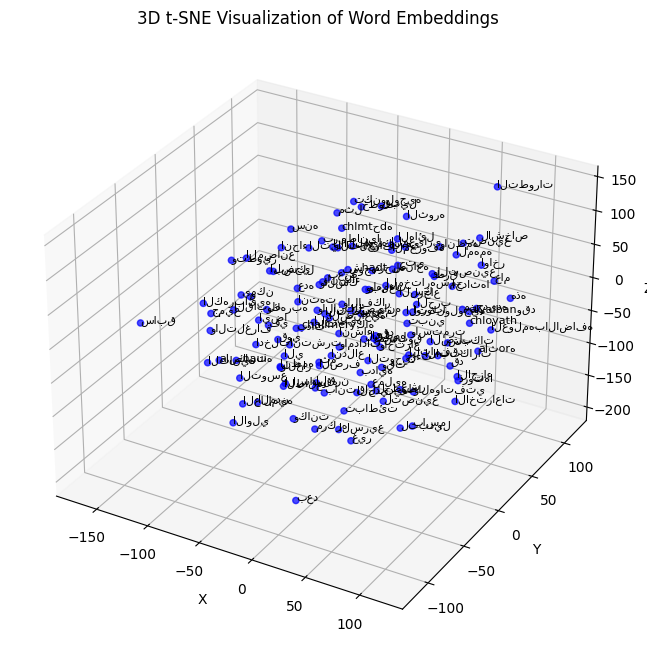

In [25]:
# Extract word embeddings for all words in the vocabulary
word_vectors = model.wv[model.wv.index_to_key]  # Get all the word vectors
words = model.wv.index_to_key  # Get the list of words

# Apply t-SNE to reduce the dimensionality of the word vectors to 3D
tsne = TSNE(n_components=3, random_state=42)
word_vectors_3d = tsne.fit_transform(word_vectors)

# Create a 3D plot using matplotlib
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points in the 3D space
ax.scatter(word_vectors_3d[:, 0], word_vectors_3d[:, 1], word_vectors_3d[:, 2], c='blue', marker='o', alpha=0.7)

# Add labels next to the points representing the words
for i, word in enumerate(words):
    ax.text(word_vectors_3d[i, 0], word_vectors_3d[i, 1], word_vectors_3d[i, 2], word, fontsize=8)

# Add titles and axis labels
ax.set_title("3D t-SNE Visualization of Word Embeddings")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Display the plot
plt.show()

